# CEV and Jackpot distribution analysis for Nitro Expressos

In [1]:
import os
import io
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

USERNAME = "_SKR"

STACK = 300
DIR = './history'
SUMMARIES_FILE = './subfiles/summaries.dat'
DF_FILE = f'./dataset.csv'
BLINDS_TAG = "*** ANTE/BLINDS ***"
FLOP_TAG = "*** FLOP ***"
TURN_TAG = "*** TURN ***"
RIVER_TAG = "*** RIVER ***"
SHOWDOWN_TAG = "*** SHOW DOWN ***"


### Hand preprocessing

In [2]:
class Expresso():
    def __init__(self, _id, _buy_in, _prizepool, _position, _history_path):
        self.id = _id
        self.buy_in = _buy_in
        self.multiplier = _prizepool // _buy_in
        self.position = _position
        self.result = -_buy_in
        if self.multiplier < 50:
            if _position == 1:
                self.result += _prizepool
        else:
            if _position == 1:
                self.result += int(_prizepool * .8)
            elif _position == 2:
                self.result += int(_prizepool * .12)
            else:
                self.result += int(_prizepool * .08)
        self.cev = 2 * STACK if _position == 1 else -STACK
        self.adjusted_cev = self.cev
        self.history_path = _history_path
        self.hands = []
        
class All_in_hand():
    def __init__(self, _hero_hand, _vilain_hand, _board, _final_board, _pot, _hero_bet):
        self.hero_hand = _hero_hand
        self.vilain_hand =_vilain_hand
        self.board = _board
        self.final_board = _final_board
        self.pot = _pot
        self.hero_bet = _hero_bet
        self.real_equity = -1
        self.adjusted_equity = -1
        self.chip_adjust = 0
        
def get_text_between(string, left_bound, right_bound=None):
    start = string.find(left_bound)+len(left_bound)
    return string[start:start+1] if right_bound is None else string[start:start+string[start:].find(right_bound)]

def parse_actions(acts, pmap):
    round_bets = [0, 0, 0]
    for line in acts:
        l = line.split()
        if l:
            if l[0] in pmap:
                p = pmap[l[0]]
                l = [x for x in l if x.isdigit()]
                if len(l) == 2:
                    round_bets[p] = int(l[1])
                elif len(l) == 1:
                    round_bets[p] += int(l[0])
    return round_bets

def load_summaries():
    games_paths = os.listdir(DIR)
    games = []
    for g in games_paths:
        if g[-11:] == "summary.txt" and "Nitro" in g:
            g_id = get_text_between(g, "(", ")")
            path = os.path.join(DIR, g)
            with io.open(path, mode="r", encoding="utf-8") as f:
                content = f.read()
            g_bi = float(get_text_between(content, "Buy-In : ", "€")) + float(get_text_between(content, "+ ", "€"))
            g_pp = float(get_text_between(content, "Prizepool : ", "€"))
            g_pos = int(get_text_between(content, "You finished in "))
            g_path = path.replace("_summary", "")
            games.append(Expresso(g_id, g_bi, g_pp, g_pos, g_path))

    return games


def get_all_in_hands(games):

    hero_hands, vilain_hands, boards, final_boards = [], [], [], []
    for game in games:

        with io.open(game.history_path, mode="r", encoding="utf-8") as f:
            content = f.read().split('\n\n\n')

        players_map = {}
        for seat in range(1,4):
            players_map[get_text_between(content[0], f"Seat {seat}: ", " (")] = seat - 1

        for hand in content:
            if hand.count("shows") == 2 and USERNAME + " shows [" in hand:
                flop_x = hand.find(FLOP_TAG)
                turn_x = hand.find(TURN_TAG)
                river_x = hand.find(RIVER_TAG)
                sd_x = hand.find(SHOWDOWN_TAG)
                flop_actions = hand[flop_x:turn_x].count('\n') - 1
                turn_actions = hand[turn_x:river_x].count('\n') - 1
                river_actions = hand[river_x:sd_x].count('\n') - 1
                board = None
                if not flop_actions:
                    board = "none"
                elif not turn_actions:
                    board = get_text_between(hand, FLOP_TAG, "\n")
                elif not river_actions:
                    board = get_text_between(hand, TURN_TAG, "\n")
                if board is not None:
                    if board:
                        board = board.replace("][", " ").replace("[", "").replace("]", "").replace(" ", "")
                    hero_cards = get_text_between(hand, USERNAME + " shows [", "]").replace(" ", "")
                    hand = hand.replace(USERNAME + " shows [", "")
                    vilain_cards = get_text_between(hand, "shows [", "]").replace(" ", "")
                    total_bets = [0, 0, 0]
                    pf_action = get_text_between(hand, BLINDS_TAG, FLOP_TAG).split('\n')
                    for i, bet in enumerate(parse_actions(pf_action, players_map)):
                        total_bets[i] += bet
                    if flop_actions:
                        f_action = get_text_between(hand, FLOP_TAG, TURN_TAG).split('\n')
                        for i, bet in enumerate(parse_actions(f_action, players_map)):
                            total_bets[i] += bet
                    if turn_actions:
                        t_action = get_text_between(hand, TURN_TAG, RIVER_TAG).split('\n')
                        for i, bet in enumerate(parse_actions(t_action, players_map)):
                            total_bets[i] += bet
                    total_bets = sorted(total_bets)
                    total_bets[2] = total_bets[1]
                    pot = sum(total_bets)
                    final_board = get_text_between(hand, "Board: [", "]").replace(" ", "")
                    game.hands.append(All_in_hand(hero_cards, vilain_cards, board, final_board, pot, total_bets[2]))
                    hero_hands.append(hero_cards)
                    vilain_hands.append(vilain_cards)
                    boards.append(board)
                    final_boards.append(final_board)
    with open('./subfiles/hero_hands.txt','w') as f:
        f.write('\n'.join(hero_hands))
    with open('./subfiles/vilain_hands.txt','w') as f:
        f.write('\n'.join(vilain_hands))
    with open('./subfiles/boards.txt','w') as f:
        f.write('\n'.join(boards))
    with open('./subfiles/final_boards.txt','w') as f:
        f.write('\n'.join(final_boards))

def calculate_cev(games):
    while not os.path.isfile('./subfiles/real_equities.txt'):
        input("Run C++ equity calculations then press Enter to continue")
    with open('./subfiles/real_equities.txt','r') as f:
        real_equities = [*map(float, f.read().split('\n')[:-1])]
    with open('./subfiles/adjusted_equities.txt','r') as f:
        adjusted_equities = [*map(float, f.read().split('\n')[:-1])]
    current_index = 0
    for game in games:
        for hand in game.hands:
            hand.real_equity = real_equities[current_index]
            hand.adjusted_equity = adjusted_equities[current_index]
            current_index += 1
            hand.chip_adjust = hand.pot * (hand.adjusted_equity - hand.real_equity)
            game.adjusted_cev += hand.chip_adjust

In [3]:
if os.path.isfile(DF_FILE):
    df = pd.read_csv(DF_FILE)
else:
    games = load_summaries()
    get_all_in_hands(games)
    calculate_cev(games)
    df = pd.DataFrame([game.__dict__ for game in games])
    df = df.drop(['id', 'history_path', 'hands'], axis=1)
    df.to_csv(DF_FILE, index=False)
    
df.head()

,buy_in,multiplier,position,result,cev,adjusted_cev
0,1.0,2.0,2,-1.0,-300,-19.77764
1,1.0,2.0,1,1.0,600,60.36499
2,1.0,2.0,2,-1.0,-300,-42.34884
3,1.0,2.0,2,-1.0,-300,-92.55876
4,1.0,2.0,2,-1.0,-300,-300.00000


### Statistical overview

In [4]:
def wr_to_cev(wr):
    return STACK * (3 * wr / 100. - 1)

def cev_to_wr(cev):
    return 100 * (cev + STACK) / (3 * STACK)

def ev_insights(ds, window=None):
    if window is not None:
        ds = ds.iloc[window[0]:window[1]]
        
    stat_df = pd.DataFrame()
    stat_df["CEV"] = ds['cev'].cumsum()
    stat_df["Adjusted CEV"] = ds['adjusted_cev'].cumsum()
    stat_df["Average CEV"] = ds['cev'].expanding().mean()
    stat_df["Average Adjusted CEV"] = ds['adjusted_cev'].expanding().mean()
    
    print(f"Winrate / Expected winrate: {cev_to_wr(stat_df.iloc[-1]['Average CEV']):.2f} / {cev_to_wr(stat_df.iloc[-1]['Average Adjusted CEV']):.2f}")
    print(f"CEV / Adjusted CEV: {stat_df.iloc[-1]['Average CEV']:.2f} / {stat_df.iloc[-1]['Average Adjusted CEV']:.2f}", end='\n\n')
    
    mult_df = pd.DataFrame()
    won_ds = ds[ds['position']==1]
    mult_df["mult distribution"] = ds["multiplier"].value_counts() / ds.shape[0]
    mult_df["won mult distribution"] = won_ds["multiplier"].value_counts() / won_ds.shape[0]
    mult_df["mult total"] = ds["multiplier"].value_counts()
    mult_df["won mult total"] = won_ds["multiplier"].value_counts()
    mult_df["won mult distribution"] = mult_df["won mult distribution"].fillna(0)
    mult_df["won mult total"] = mult_df["won mult total"].fillna(0)
    mult_df = mult_df.astype({'won mult total':'int'})
    print(mult_df)
    
    sns.lineplot(data=ds['result'].cumsum(), linewidth=.5).set(title='Total evolution of winnings')
    plt.show()
    sns.lineplot(data=stat_df[["CEV", "Adjusted CEV"]], linewidth=.5).set(title='Total evolution of CEV and adjusted CEV')
    plt.show()
    sns.lineplot(data=stat_df[["Average CEV", "Average Adjusted CEV"]], linewidth=.5).set(title='Average evolution of CEV and adjusted CEV')
    plt.show()

##### Analyse globale

Winrate / Expected winrate: 36.56 / 35.54
CEV / Adjusted CEV: 29.08 / 19.84

      mult distribution  won mult distribution  mult total  won mult total
2.0            0.598796               0.600784        2088             766
3.0            0.259822               0.264314         906             337
4.0            0.082592               0.078431         288             100
5.0            0.043304               0.034510         151              44
10.0           0.014913               0.020392          52              26
50.0           0.000574               0.001569           2               2


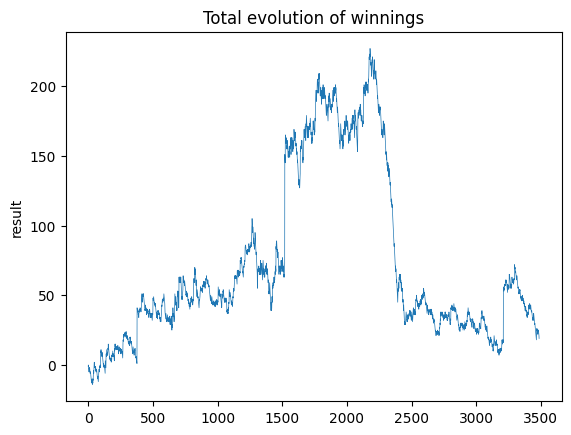

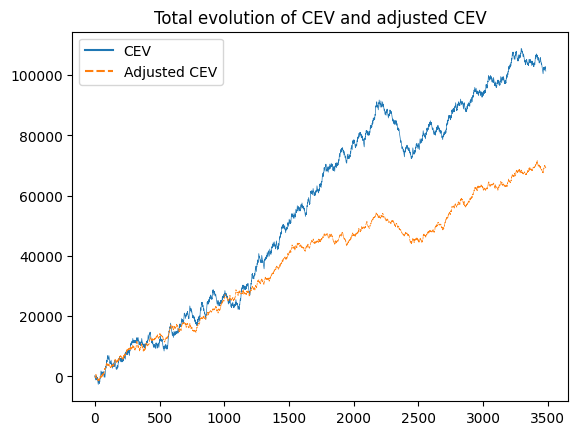

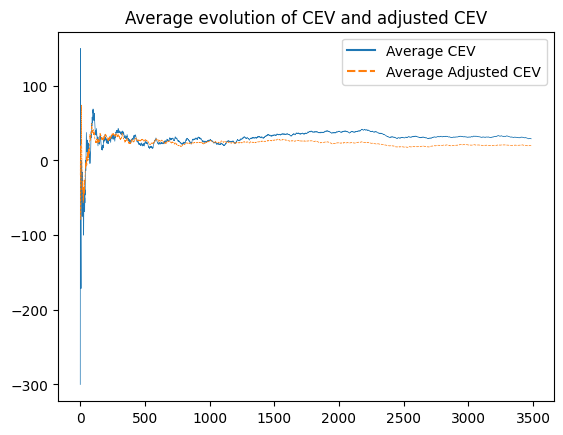

In [5]:
ev_insights(df)

##### Analyse de la période perdante

Winrate / Expected winrate: 25.12 / 29.48
CEV / Adjusted CEV: -73.95 / -34.67

      mult distribution  won mult distribution  mult total  won mult total
2.0            0.623256               0.703704         134              38
3.0            0.232558               0.203704          50              11
4.0            0.083721               0.055556          18               3
5.0            0.046512               0.037037          10               2
10.0           0.013953               0.000000           3               0


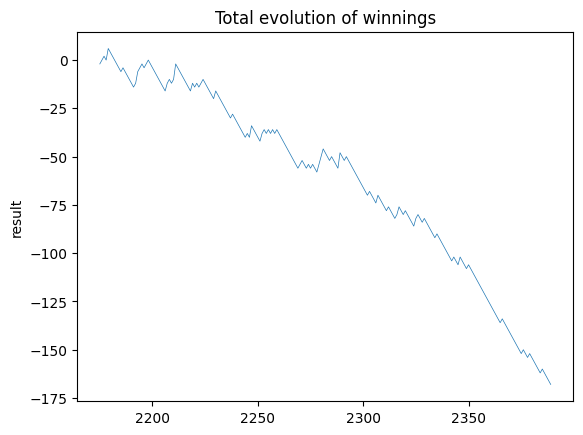

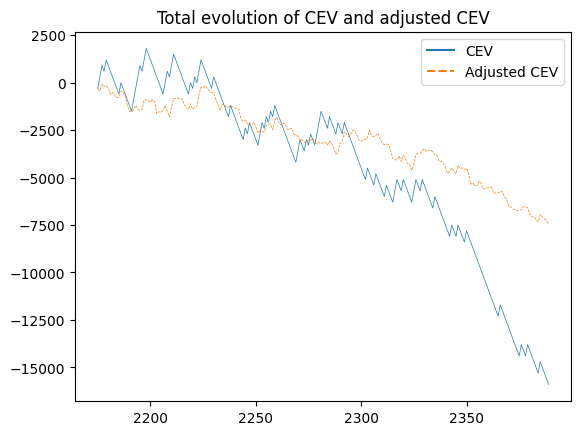

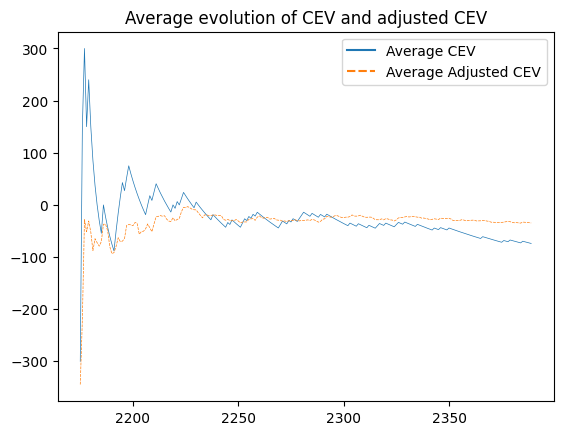

In [6]:
ev_insights(df, (2175, 2390))

##### Analyse par buy-in

In [7]:
def buy_in_insights(buy_in):
    ev_insights(df[df["buy_in"]==buy_in].reset_index())

Winrate / Expected winrate: 36.57 / 36.18
CEV / Adjusted CEV: 29.11 / 25.65

      mult distribution  won mult distribution  mult total  won mult total
2.0            0.585812               0.579474        1280             463
3.0            0.273684               0.285357         598             228
4.0            0.077346               0.068836         169              55
5.0            0.046224               0.041302         101              33
10.0           0.016476               0.023780          36              19
50.0           0.000458               0.001252           1               1


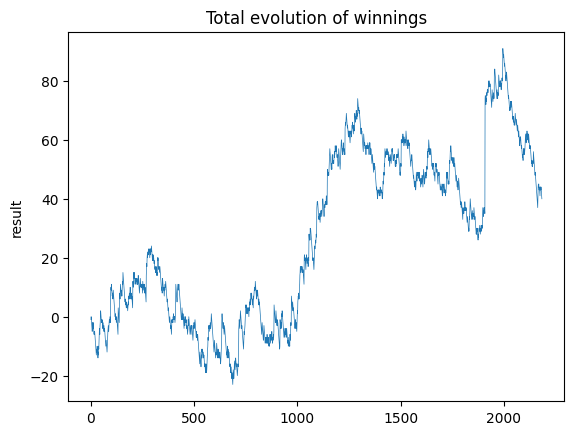

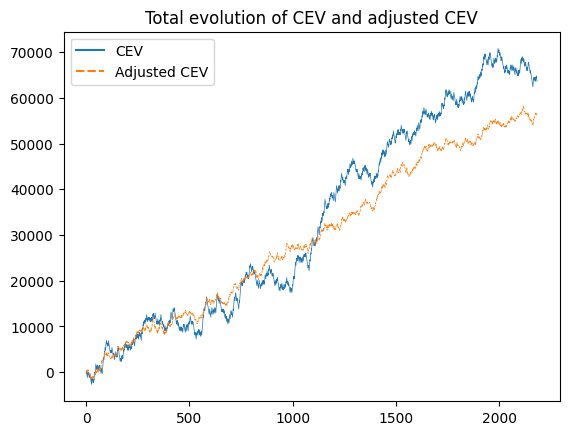

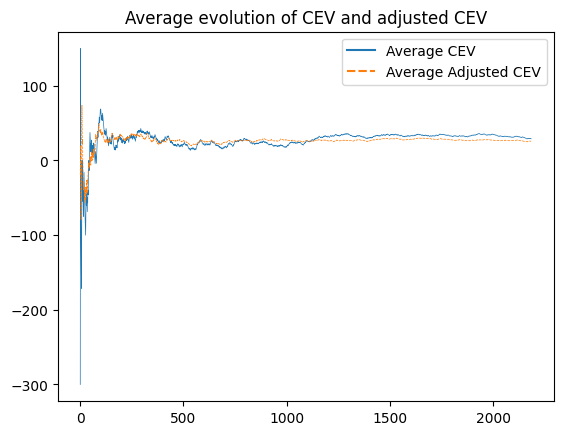

In [8]:
buy_in_insights(1)

Winrate / Expected winrate: 36.48 / 34.39
CEV / Adjusted CEV: 28.28 / 9.53

      mult distribution  won mult distribution  mult total  won mult total
2.0            0.621329               0.637712         804             301
3.0            0.235703               0.228814         305             108
4.0            0.091963               0.095339         119              45
5.0            0.037867               0.021186          49              10
10.0           0.012365               0.014831          16               7
50.0           0.000773               0.002119           1               1


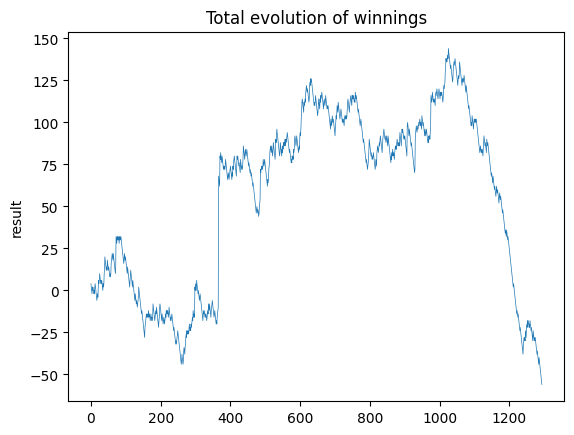

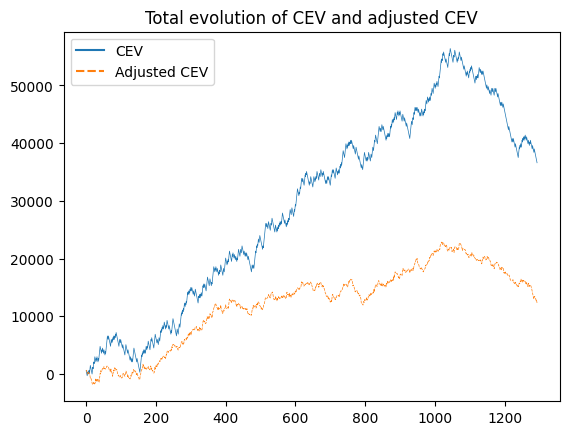

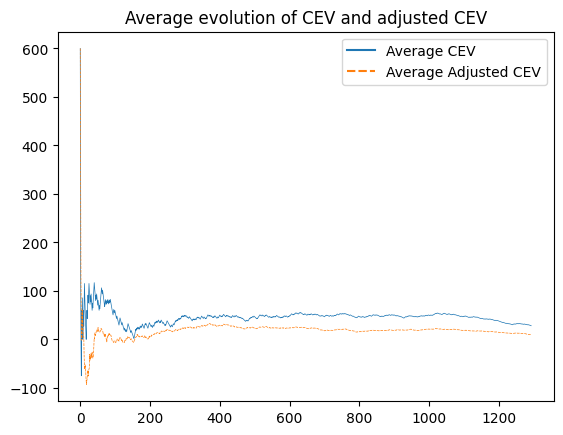

In [10]:
buy_in_insights(2)